In [87]:
import numpy as np
import pandas as pd
import scipy as sp
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.special.orthogonal import p_roots
import scipy.integrate

In [88]:
#Точки и вес Гаусса-Лежандра
def gauss_xw(m=100):
    point,weight=p_roots(m+1)
    return point,weight

In [89]:
#Точное решение
def function_u(x):
    return x**(3/4)

In [90]:
#Функция в правом конце уравнения
def f_function(x):
    return 3/16*x**(-5/4)

In [91]:
#Строим набор базисных ф-й пространства (x - переменные, n - кол-во узлов, i - i-й узел, t - список узлов, h - список шагов)
def hat_function(x,t,i,h,n):
    if i==n:
        if t[n]>=x and x>=t[n-1]:
            return 1+(x-t[n])/h[n-1]
        else:
            return 0
    else:
        if t[i]>=x and x>=t[i-1]:
            return 1+(x-t[i])/h[i-1]
        elif t[i+1]>=x and x>=t[i]:
            return 1-(x-t[i])/h[i]
        else:
            return 0

In [92]:
#Рассчитать правильный член уравнения (h - список шагов, a, b - начало и конец интервала)
def compute_right_of_equation(point,weight,t,h,n,a,b):
    c=(b-a)/2
    s = (b-a) / 2 * point + (a + b) / 2 # Изменить интервал [a, b] на [-1,1]
    f=[sum([c*weight[i]*f_function(s[i])*hat_function(s[i],t,j,h,n) for i in range(len(s))])
            for j in range(1,len(t)-1)]
    f [-1] = f [-1] + 1 / h [-1] # Добавить правильное начальное условие
    return f

In [93]:
#Рассчитать матрицу кф(матрицу общей жесткости)
def compute_stiffness_matrix(point,weight,t,h,n,a,b):
    A=np.zeros((n-1,n-1))
    for j in range(1,len(t)-1):
        if j==1:
            A[j-1,j-1]=+sp.integrate.quad(lambda x: h[j]**(-2),t[j-1],t[j+1])[0]
                   #sp.integrate.quad(lambda x: h[j]**(-2),t[j],t[j+1])[0]
            A[j-1,j]=sp.integrate.quad(lambda x: -h[j]**(-2),t[j],t[j+1])[0]
            #A[j,j-1]=sp.integrate.quad(lambda x: h[j]**(-2),t[j-1],t[j])[0]
        
        elif j==n-1:
            A[j-1,j-2]=sp.integrate.quad(lambda x: -h[j-1]**(-2),t[j-1],t[j])[0]
            A[j-1,j-1]=+sp.integrate.quad(lambda x: h[j-1]**(-2),t[j-1],t[j+1])[0]
        else:
            A[j-1,j-2]=sp.integrate.quad(lambda x: -h[j-1]**(-2),t[j-1],t[j])[0]
            A[j-1,j-1]=+sp.integrate.quad(lambda x: h[j-1]**(-2),t[j-1],t[j])[0]+\
                   sp.integrate.quad(lambda x: h[j]**(-2),t[j],t[j+1])[0]
            A[j-1,j]=sp.integrate.quad(lambda x: -h[j]**(-2),t[j],t[j+1])[0]
    return np.array(A)


In [94]:
#Точное решение
def solve_ui(A,b):
    return np.linalg.solve(A,np.array(b))

In [95]:
#Приближенное решение и погрешность
def solve_uh(ui,t,h,n,a,b):
    uh=[sum([ui[j]*hat_function(x,t,j+1,h,n) for j in range(n-1)]) for x in t if x!=1]
    error=function_u(np.array(t[:-1]))-uh
    return uh,LA.norm(error,np.inf)

The error is: 6.331166206265809e-05


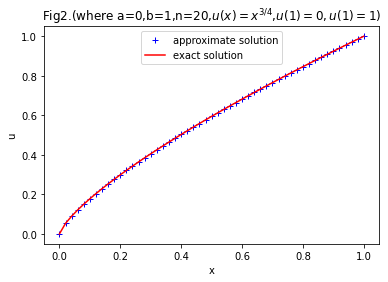

In [96]:
if __name__ == '__main__':
    a = 0
    b=1
    n=50
    h = (b-a) / (n) # равноудаленный шаг
    t = [a + i * h for i in range (0, n + 1)] # узел
    h = [(b-a) / (n) for i in range (n)] # Размер шага подинтервала 
    
    point, weight = gauss_xw (m = 100) # точка и вес узла Гаусса-Жордана
    f = compute_right_of_equation (point, weight, t, h, n, a, b) # Рассчитать правильный член уравнения
    A = compute_stiffness_matrix (point, weight, t, h, n, a, b) # Рассчитать матрицу кф(матрица жесткости)
    ui = solve_ui (A, f) # Вычислить пользовательский интерфейс
    
    uh, error = solve_uh (ui,t,h,n,a,b)
    
    print('The error is:',error)
    plt.plot(t,[0]+list(ui)+[1],'+b',label='approximate solution')
    plt.plot(t,function_u(np.array(t)),'r',label='exact solution')
    plt.title('Fig2.(where a=0,b=1,n=20,$u(x)=x^{3/4}$,$u(1)=0,u(1)=1$)')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend(loc='upper center')